<a href="https://colab.research.google.com/github/Sonal-kumar1998/ANN_Based_Device_Modelling/blob/main/Charge_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm import tqdm
import time

In [ ]:
data_path = "/content/drive/MyDrive/DDP/AC_Model/Data/AC_Characterisation.csv"
training_dataset = pd.read_csv(data_path) 
training_dataset.head()

,"#""frequency""",v(d),v(s),v(g),v(b),"c(d,d)","c(d,s)","c(d,g)","c(d,b)","c(s,d)","c(s,s)","c(s,g)","c(s,b)","c(g,d)","c(g,s)","c(g,g)","c(g,b)","c(b,d)","c(b,s)","c(b,g)","c(b,b)"
0,2.400000e+09,-7.120000e-42,7.120000e-42,0.0,0.0,7.120000e-15,7.930000e-17,-6.110000e-15,-1.090000e-15,7.930000e-17,7.760000e-16,-4.340000e-16,-4.210000e-16,-6.110000e-15,-4.340000e-16,6.630000e-15,-8.550000e-17,-1.090000e-15,-4.210000e-16,-8.550000e-17,1.600000e-15
1,2.400000e+09,8.000000e-03,7.120000e-42,0.0,0.0,7.090000e-15,6.960000e-17,-6.070000e-15,-1.090000e-15,4.940000e-17,7.750000e-16,-4.070000e-16,-4.170000e-16,-6.050000e-15,-4.240000e-16,6.560000e-15,-8.560000e-17,-1.090000e-15,-4.200000e-16,-8.590000e-17,1.590000e-15
2,2.400000e+09,1.600000e-02,-1.270000e-33,0.0,0.0,7.050000e-15,6.160000e-17,-6.020000e-15,-1.090000e-15,2.760000e-17,7.740000e-16,-3.870000e-16,-4.140000e-16,-5.990000e-15,-4.160000e-16,6.490000e-15,-8.630000e-17,-1.080000e-15,-4.200000e-16,-8.670000e-17,1.590000e-15
3,2.400000e+09,2.400000e-02,-3.820000e-33,0.0,0.0,6.990000e-15,5.570000e-17,-5.960000e-15,-1.090000e-15,1.270000e-17,7.730000e-16,-3.740000e-16,-4.120000e-16,-5.920000e-15,-4.100000e-16,6.420000e-15,-8.730000e-17,-1.080000e-15,-4.190000e-16,-8.780000e-17,1.590000e-15
4,2.400000e+09,3.200000e-02,-5.220000e-30,0.0,0.0,6.910000e-15,5.160000e-17,-5.880000e-15,-1.080000e-15,3.040000e-18,7.730000e-16,-3.650000e-16,-4.110000e-16,-5.840000e-15,-4.060000e-16,6.340000e-15,-8.860000e-17,-1.070000e-15,-4.180000e-16,-8.910000e-17,1.580000e-15


#Convert dataset into pytorch input and output format  



In [ ]:
#data_path = "/content/drive/MyDrive/DDP/AC_Model/Data/AC_Characterisation.csv"
class training_dataset(Dataset):
  def __init__(self):
  
    data_set = pd.read_csv(data_path)                     # directory of the training dataset
    column_x = ["v(d)",	"v(g)",	"v(b)"]                   #input column of the training dataset
    column_y = ["c(d,d)", "c(d,g)","c(d,b)"]              #output column of the trainng datset

    self.x = torch.tensor(data_set[column_x].values, requires_grad= True) 
    self.y = torch.tensor(data_set[column_y].values)*10**15     
    self.n_samples = data_set.shape[0]                   

  def __getitem__(self , index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples

###################################################
dataset = training_dataset()     # class of the dataset
first_data = dataset[0]          # first element of the dataset
feature, label = first_data      # feature and label of the dataset
print(feature)
print(label)
print(f"Total number of sample in training dataset is {len(dataset)}")

tensor([-7.1200e-42,  0.0000e+00,  0.0000e+00], dtype=torch.float64,
       grad_fn=<SelectBackward0>)
tensor([ 7.1200, -6.1100, -1.0900], dtype=torch.float64)
Total number of sample in training dataset is 113726


#Divide the training dataset into batch of training dataset

In [ ]:
batch_size = 128                                                   # number of sample in one batch
training_set = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle= True)
print(f"Total number of batch in trainig dataset is {len(training_set)}")

Total number of batch in trainig dataset is 889


# Defined the pytorch model

In [ ]:
class Model(nn.Module):
    def __init__(self,n_feature):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(n_feature,10)
        self.lin2 = nn.Linear(10,10)
        self.lin3 = nn.Linear(10,5)
        self.lin4 = nn.Linear(5,1)
        #self.lin5 = nn.Linear(10,1)
    def forward(self, x):
        x = torch.tanh(self.lin1(x))
        x = torch.tanh(self.lin2(x))
        x = torch.tanh(self.lin3(x))
        x = self.lin4(x)
        #x = self.lin5(x)
        return x

#Defined loss function of the model


In [ ]:
def my_loss(output, input, target):
  dydx = torch.autograd.grad(output, input, grad_outputs=output.data.new(output.shape).fill_(1),
  create_graph=True, retain_graph=True)[0]
  loss = torch.mean((dydx - target)**2)
  return loss

# Create the instance of Model and defined the optimizer

In [ ]:
model = Model(n_feature = 3)                                                 # model instance 
learning_rate = 0.001                                                        # learning rate
#criterion = torch.nn.MSELoss()                                              # inbuilt loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)           # optimizer of ANN Model

#Training Loop

In [ ]:
num_epochs = 2
n_total_steps = len(training_set)
for epoch in range(num_epochs):
  for i,(x_train, y_train) in tqdm(enumerate(training_set), desc = 'Number of iteration'):
    x_train  = x_train.float()
    y_train  = y_train.float()
    x_train.requires_grad_(True)
    outputs = model(x_train)
    
    # Calculation of the loss 
    loss = my_loss(outputs,x_train, y_train)
    
    #Calculation of gradient of loss with respect to the model parameter
    loss.backward() 

    #Update the Model parameter  
    optimizer.step() 

    #initialized the derivative to zero
    optimizer.zero_grad()     
     
    # if (i+1)% 100 ==0:
    #   print(f"epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss ={loss.item():.4f}")
  print(f" epoch {epoch+1}/{num_epochs}, loss = {loss.item():.4f}")

Number of iteration: 889it [02:41,  5.52it/s]


 epoch 1/2, loss = 0.5656


Number of iteration: 889it [02:16,  6.50it/s]

 epoch 2/2, loss = 0.1592


# Save the model as dictionary based



In [ ]:
model_path = "/content/drive/MyDrive/DDP/AC_Model/AC_Model/source_charge_model.pth"
torch.save(model.state_dict(), model_path)

#Load the model

In [ ]:
#model_path = "/content/drive/MyDrive/DDP/AC_Model/AC_Model/drain_charge_model.pth"
model = Model(n_feature = 3)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def  plot_charge(gate_volatges):
  for gate in gate_volatges:
    data_set = pd.read_csv("/content/drive/MyDrive/DDP/AC_Model/Data/AC_Characterisation.csv")
    data_set = data_set.loc[data_set["v(g)"].isin([gate])]
    data_set.sort_values(by="v(d)")
    column_x = ["v(d)",	"v(g)",	"v(b)"]
    input = torch.tensor(data_set[column_x].values , dtype = torch.float32)
    x = data_set["v(d)"]
    output = model(input)
    output = output/(10**15)
    plt.plot(x,output.detach().numpy(),label = "Vgs = "+ str(gate))
  plt.xlabel("Drain Voltage (Vds)")
  plt.ylabel("Drain terminal charge (Qd)")
  plt.title("Qd Vs Vds")
  plt.xticks(np.arange(0,9,1))
  plt.grid(b=True, which='both', axis='both')
  plt.legend(loc ="lower right")
  plt.savefig("/content/drive/MyDrive/DDP/AC_Model/Plot/Q-V_Plot/" + "source_charge")

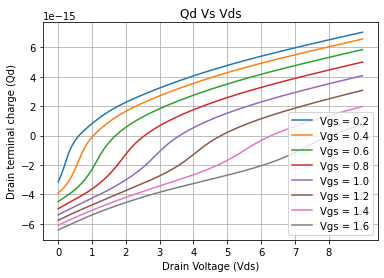

In [ ]:
plot_charge([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6])